In [1]:
#import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Create populations

In [2]:
population_size = 1000
mu_blue = 40
mu_orange = 60

#create populations
blues1 = np.random.normal(mu_blue, 5, (int(population_size/5)*4,1))
blues2 = np.random.normal(mu_blue+20, 5, (int(population_size/5),1))
blues = np.concatenate((blues1, blues2), axis=0)
oranges1 = np.random.normal(mu_orange, 5, (int(population_size/5),1))
oranges2 = np.random.normal(mu_orange+20, 5, (int(population_size/5)*4,1))
oranges = np.concatenate((oranges1, oranges2), axis=0)

blues_who_defaulted = blues < np.random.uniform(50, 150, (population_size,1))
oranges_who_defaulted = oranges < np.random.uniform(0, 100, (population_size,1))

blues_bank_thinks_defaulted = blues < 30
oranges_bank_thinks_defaulted = oranges < 60

# Plot populations

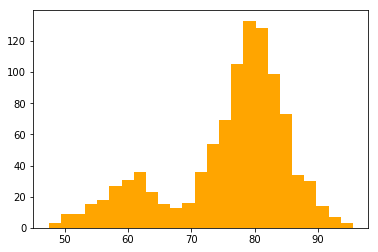

In [53]:
plt.hist(oranges, bins=25, color="orange")
plt.show()

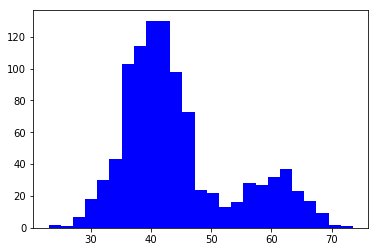

In [49]:
plt.hist(blues, bins=25, color="b")
plt.show()

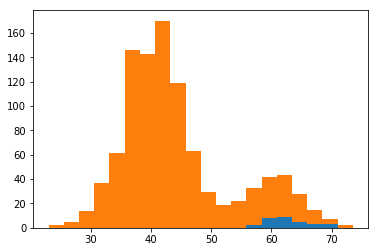

In [54]:
plt.hist([blues[np.logical_not(blues_who_defaulted)],blues[blues_who_defaulted]], stacked=True, bins=20)
plt.show()

In [5]:
#define true and false negatives/positives
true_negative_blues = np.logical_and(blues_who_defaulted, blues_bank_thinks_defaulted)
false_negative_blues = np.logical_and(np.logical_not(blues_who_defaulted), blues_bank_thinks_defaulted)
true_positive_blues = np.logical_and(np.logical_not(blues_who_defaulted), np.logical_not(blues_bank_thinks_defaulted))
false_positive_blues = np.logical_and(blues_who_defaulted, np.logical_not(blues_bank_thinks_defaulted))

In [35]:
#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return 0.8 - np.abs(true_positive_rate_group1-true_positive_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = paid_back*credit_upside - defaulted*credit_downside

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

# With fairness constraint:

In [36]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  [-473] $


In [42]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3})

x_fair = solution.x

In [43]:
#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("final guess of", x_fair, 
      "got us an average credit score change for the blues of", blues_credit_change, 
      "and an average credit score change for the oranges of", oranges_credit_change)

final guess of [81.89155344 75.46702463] got us a profit of  [236] $
final guess of [81.89155344 75.46702463] got us an average credit score change for the blues of [0] and an average credit score change for the oranges of [342]


# Optimise without fairness

In [44]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [45]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("final guess got us an average credit score change for the blues of", blues_credit_change, 
      "and an average credit score change for the oranges of", oranges_credit_change)

final guess of [77.33548295 62.49823421] got us a profit of  [179] $
final guess got us an average credit score change for the blues of [0] and an average credit score change for the oranges of [349]


In [46]:
differences_in_true_positive_rates = np.zeros((80, 80))
profit = np.zeros((80, 80))
for i in range(80):
    for j in range(80):
        true_positive_rate_blue = true_positive_rate(blues, blues_who_defaulted, i)
        true_positive_rate_orange = true_positive_rate(oranges, oranges_who_defaulted, j)
        differences_in_true_positive_rates[i,j] = np.abs(true_positive_rate_blue - true_positive_rate_orange)
        #profit[i,j], _, _ = bank_profit(blues, blues_who_defaulted, i) + bank_profit(oranges, oranges_who_defaulted, j)
    
    if(i%10 == 0):
        print(i)

0
10
20
30
40
50
60
70


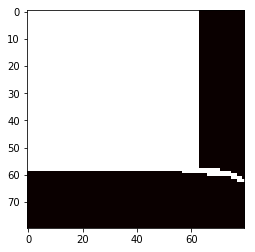

In [47]:
plt.imshow(differences_in_true_positive_rates < 0.1, cmap='hot', interpolation='nearest')
plt.show()

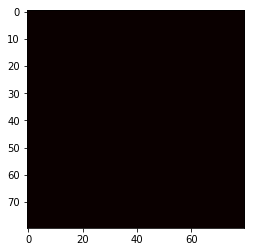

In [32]:
plt.imshow(profit, cmap='hot', interpolation='nearest')
plt.show()

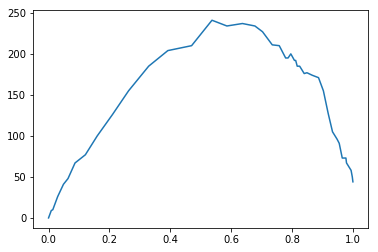

In [33]:
orange_profit = np.zeros(100)
selection_rate = np.zeros(100)
credit_change = np.zeros(100)

for i in range(100):
    orange_profit[i], selection_rate[i], credit_change[i] = bank_profit(oranges, oranges_who_defaulted, i)
    
plt.plot(selection_rate, orange_profit)
plt.show()

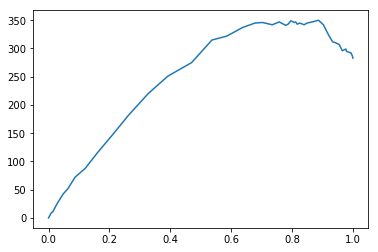

In [34]:
plt.plot(selection_rate, credit_change)
plt.show()